2025-02-12 19:41:22 INFO     [Epoch   1] Train Loss: 0.6337 | Train Acc: 65.6847 | Train Misclass: 0.3432 | Val Loss: 0.5960 | Val Acc: 69.2000 | Val Misclass: 0.3080 | BS: 64 | LR: 0.0010 | HU: 256
2025-02-12 19:41:23 INFO     [Epoch   2] Train Loss: 0.6010 | Train Acc: 68.2822 | Train Misclass: 0.3172 | Val Loss: 0.5812 | Val Acc: 70.1000 | Val Misclass: 0.2990 | BS: 64 | LR: 0.0010 | HU: 256
2025-02-12 19:41:24 INFO     [Epoch   3] Train Loss: 0.5884 | Train Acc: 68.9192 | Train Misclass: 0.3108 | Val Loss: 0.5715 | Val Acc: 70.9500 | Val Misclass: 0.2905 | BS: 64 | LR: 0.0010 | HU: 256
2025-02-12 19:41:24 INFO     [Epoch   4] Train Loss: 0.5822 | Train Acc: 69.4865 | Train Misclass: 0.3051 | Val Loss: 0.5644 | Val Acc: 71.4000 | Val Misclass: 0.2860 | BS: 64 | LR: 0.0010 | HU: 256
2025-02-12 19:41:25 INFO     [Epoch   5] Train Loss: 0.5751 | Train Acc: 70.1334 | Train Misclass: 0.2987 | Val Loss: 0.5604 | Val Acc: 72.0500 | Val Misclass: 0.2795 | BS: 64 | LR: 0.0010 | HU: 256
2025-

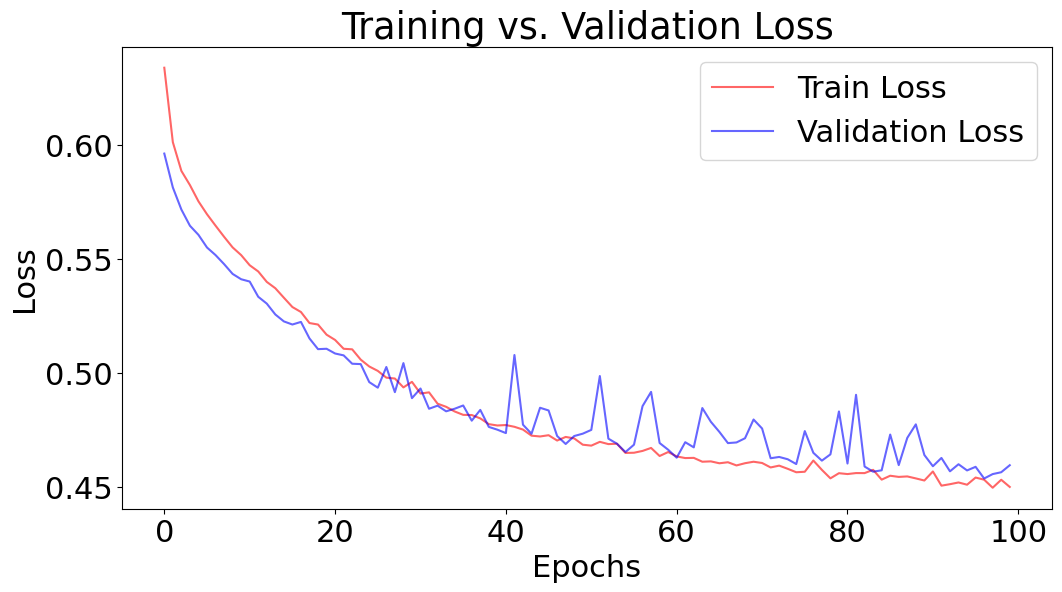

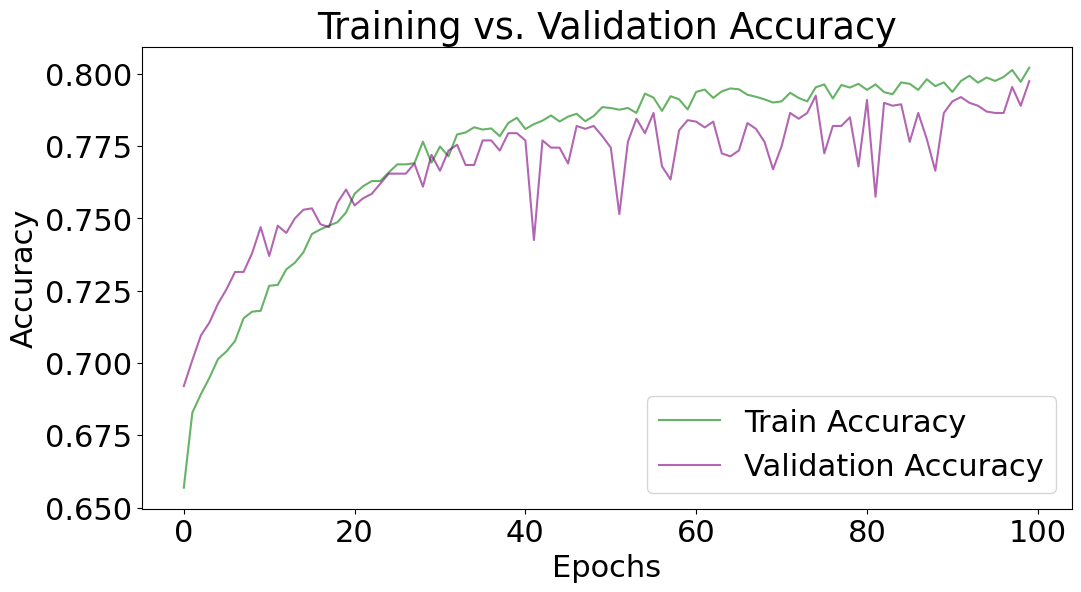

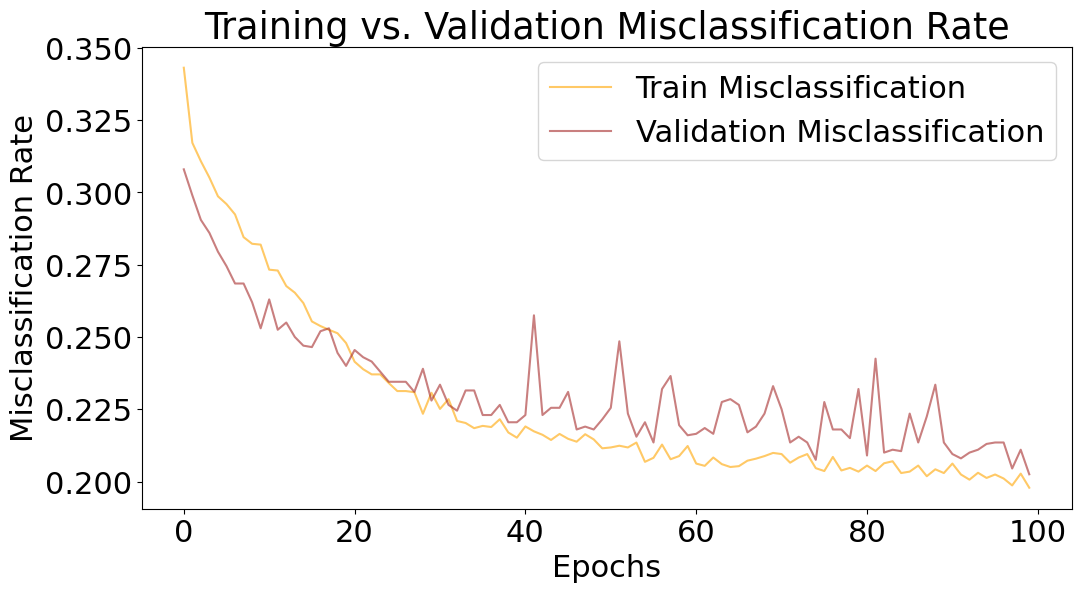

2025-02-12 19:42:37 INFO     Final Validation Accuracy: 79.7500


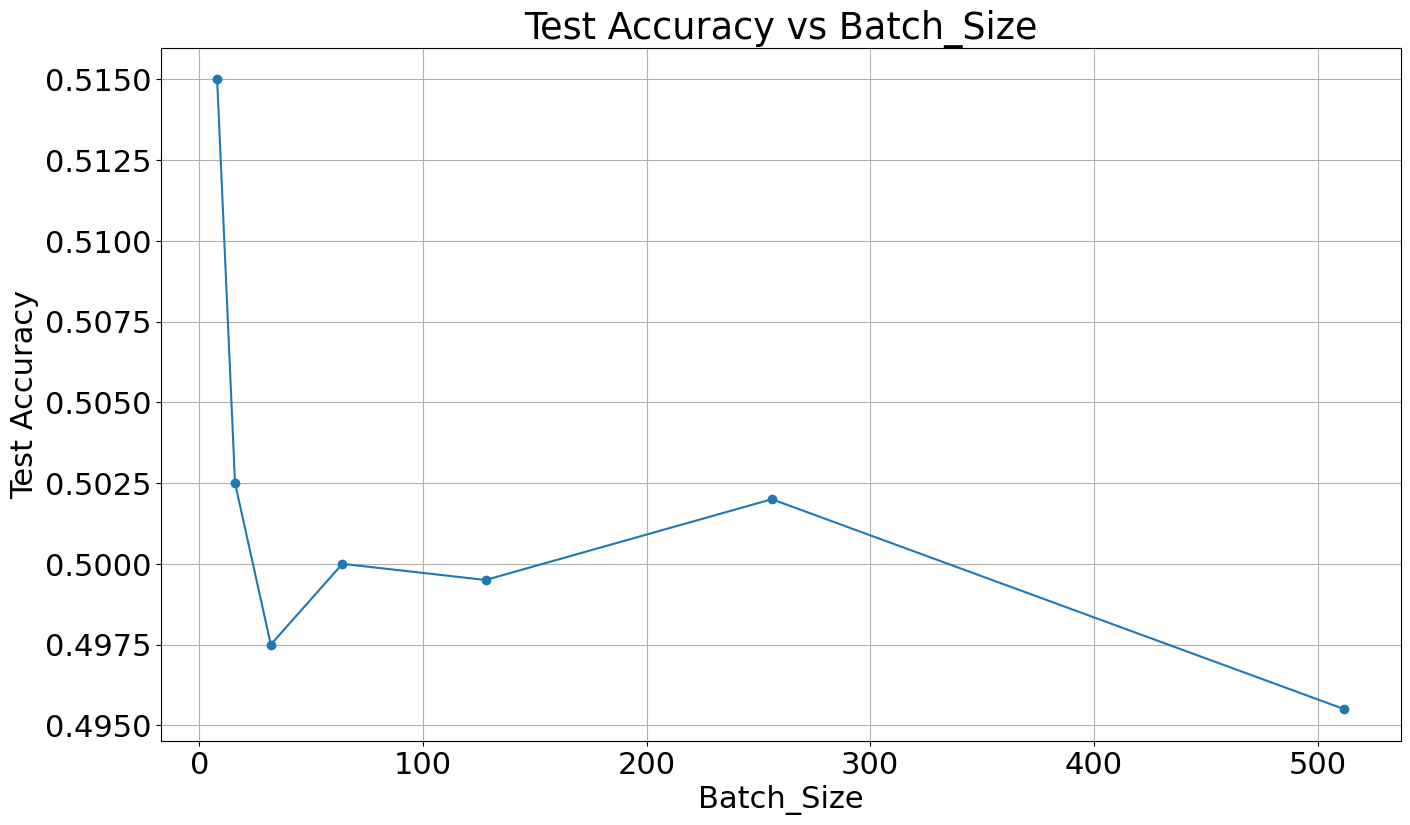

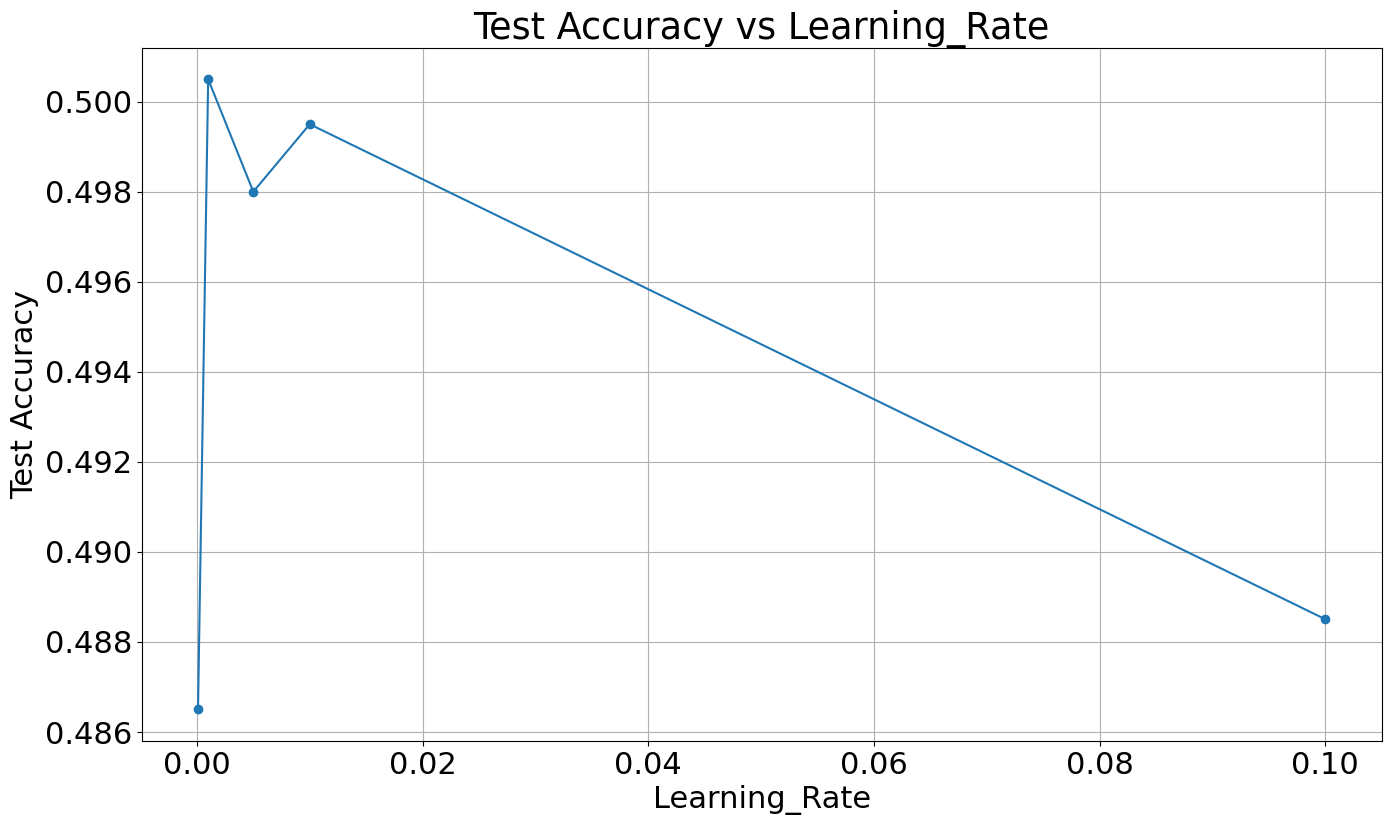

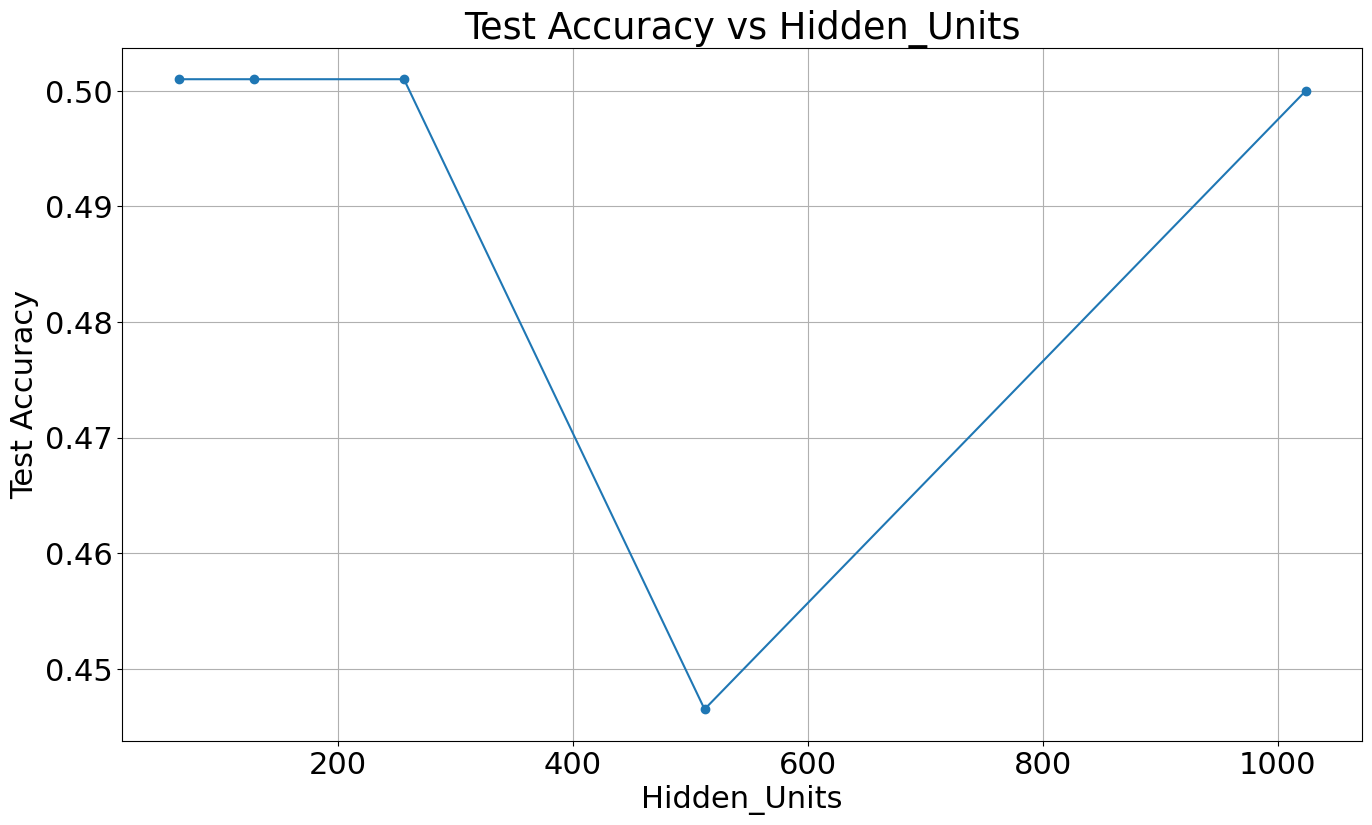

In [149]:
"""
SANKETH KARUTURI
"""

from turtle import width
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal','size'   : 22}
matplotlib.rc('font', **font)
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')


######################################################
# Q1 Implement Init, Forward, and Backward For Layers
######################################################

class SigmoidCrossEntropy:
    """
    Sigmoid Activation followed by Cross-Entropy Loss.
    """

    def forward(self, logits, labels):
        """
        Computes the sigmoid activation and cross-entropy loss.

        Args:
        - logits (numpy.ndarray): Raw output scores (before activation).
        - labels (numpy.ndarray): Ground truth labels (0 or 1).

        Returns:
        - float: Average cross-entropy loss.
        """
        self.logits = logits
        self.labels = labels
        self.sigmoid_out = 1.0 / (1.0 + np.exp(-logits))  # Compute sigmoid activation

        # Avoid log(0) by adding a small epsilon
        eps = 1e-10
        self.loss = -np.mean(
            self.labels * np.log(self.sigmoid_out + eps) +
            (1 - self.labels) * np.log(1 - self.sigmoid_out + eps)
        )
        return self.loss

    def backward(self):
        """
        Computes the gradient of the cross-entropy loss w.r.t. logits.

        Returns:
        - numpy.ndarray: Gradient of the loss with respect to the input logits.
        """
        batch_size = self.logits.shape[0]
        grad = (self.sigmoid_out - self.labels) / batch_size  # dL/dz = (sigmoid(z) - y) / batch_size
        return grad


class ReLU:
    """
    ReLU Activation Layer.
    Applies element-wise max(0, x).
    """

    def forward(self, input):
        """
        Computes the ReLU activation function.

        Args:
        - input (numpy.ndarray): Input to the layer.

        Returns:
        - numpy.ndarray: ReLU applied element-wise.
        """
        self.input = input  # Store input for backpropagation
        self.output = np.maximum(0, input)
        return self.output

    def backward(self, grad):
        """
        Computes the gradient of the loss w.r.t input.

        Args:
        - grad (numpy.ndarray): Gradient from the next layer.

        Returns:
        - numpy.ndarray: Gradient after applying ReLU derivative.
        """
        relu_grad = np.where(self.input > 0, 1.0, 0.0)  # Derivative of ReLU
        return grad * relu_grad

    def step(self, step_size, momentum=0, weight_decay=0):
        """
        No parameters to update for ReLU, so this is a no-op.
        """
        pass


class LinearLayer:
    """
    Fully Connected Linear Layer: Computes Z = XW + b.
    """

    def __init__(self, input_dim, output_dim):
        """
        Initializes the layer with random weights and zero biases.

        Args:
        - input_dim (int): Number of input features.
        - output_dim (int): Number of output features.
        """
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim + output_dim))
        self.bias = np.zeros((1, output_dim))

        # Momentum terms for weight updates
        self.vw = np.zeros_like(self.weights)
        self.vb = np.zeros_like(self.bias)

    def forward(self, input):
        """
        Computes the forward pass: Z = XW + b.

        Args:
        - input (numpy.ndarray): Input data of shape (batch_size, input_dim).

        Returns:
        - numpy.ndarray: Output of shape (batch_size, output_dim).
        """
        self.input = input  # Store input for backpropagation
        self.output = input.dot(self.weights) + self.bias
        return self.output

    def backward(self, grad):
        """
        Computes gradients for backpropagation.

        Args:
        - grad (numpy.ndarray): Gradient of loss w.r.t output.

        Returns:
        - numpy.ndarray: Gradient of loss w.r.t input.
        """
        self.grad_weights = self.input.T.dot(grad)  # Gradient w.r.t. weights
        self.grad_bias = np.sum(grad, axis=0, keepdims=True)  # Gradient w.r.t. bias
        grad_input = grad.dot(self.weights.T)  # Gradient w.r.t. input
        return grad_input

    def step(self, step_size, momentum=0.8, weight_decay=0.01):
        """
        Updates weights and biases using SGD with momentum and weight decay.

        Args:
        - step_size (float): Learning rate.
        - momentum (float): Momentum factor.
        - weight_decay (float): Regularization factor.
        """
        dW = self.grad_weights + weight_decay * self.weights  # Apply weight decay
        self.vw = momentum * self.vw - step_size * dW  # Momentum update
        self.weights += self.vw

        db = self.grad_bias
        self.vb = momentum * self.vb - step_size * db  # Momentum update for bias
        self.bias += self.vb


######################################################
# Q4 Implement Evaluation for Monitoring Training
###################################################### 

def evaluate(model, X_val, Y_val, batch_size):
    """
    Evaluates the model on the validation set.

    Returns:
    - avg_loss: Average cross-entropy loss over the batch
    - avg_acc: Average accuracy over the batch
    - misclassification_error: Misclassification error rate (1 - accuracy)
    """
    ce = SigmoidCrossEntropy()
    num_examples = X_val.shape[0]

    total_loss = 0.0
    total_correct = 0
    total_misclassified = 0

    for i in range(0, num_examples, batch_size):
        Xb = X_val[i:i+batch_size]
        Yb = Y_val[i:i+batch_size]

        logits = model.forward(Xb)
        batch_loss = ce.forward(logits, Yb)
        total_loss += batch_loss * Xb.shape[0]

        # Predictions: (logit >= 0) => class = 1
        preds = (ce.sigmoid_out >= 0.5).astype(int)
        correct = np.sum(preds == Yb)
        misclassified = np.sum(preds != Yb)

        total_correct += correct
        total_misclassified += misclassified

    avg_loss = total_loss / num_examples
    avg_acc = total_correct / num_examples
    misclassification_error = total_misclassified / num_examples  

    return avg_loss, avg_acc, misclassification_error  

def train_model(net, X_train, Y_train, X_test, Y_test, 
                batch_size=64, max_epochs=100, step_size=0.001, 
                weight_decay=0.05, momentum=0.8):
    """
    Trains a FeedForward Neural Network and logs required metrics.
    - Returns loss, accuracy, and misclassification error rates.
    """

    num_examples, input_dim = X_train.shape

    ce = SigmoidCrossEntropy()

    # Lists to store metrics for each epoch
    losses, val_losses = [], []
    accs, val_accs = [], []
    misclassification_train, misclassification_test = [], []

    for epoch in range(max_epochs):
        # Shuffle training data
        idx = np.random.permutation(num_examples)
        X_train, Y_train = X_train[idx], Y_train[idx]

        epoch_losses, epoch_accs, epoch_misclassifications = [], [], []

        for b in range(0, num_examples, batch_size):
            Xb = X_train[b:b+batch_size]
            Yb = Y_train[b:b+batch_size]

            # Forward pass
            logits = net.forward(Xb)
            batch_loss = ce.forward(logits, Yb)
            grad_logits = ce.backward()

            # Backward pass
            net.backward(grad_logits)
            net.step(step_size, momentum, weight_decay)

            # Calculate batch accuracy & misclassification error
            preds = (ce.sigmoid_out >= 0.5).astype(int)
            batch_acc = np.mean(preds == Yb)
            batch_misclass = np.mean(preds != Yb)

            # Store batch metrics
            epoch_losses.append(batch_loss)
            epoch_accs.append(batch_acc)
            epoch_misclassifications.append(batch_misclass)

        # Compute epoch-level metrics
        epoch_avg_loss = np.mean(epoch_losses)
        epoch_avg_acc = np.mean(epoch_accs)
        epoch_avg_misclass = np.mean(epoch_misclassifications)

        # Evaluate on the test set
        val_loss, val_acc, val_misclass = evaluate(net, X_test, Y_test, batch_size)

        # Store results
        losses.append(epoch_avg_loss)
        val_losses.append(val_loss)
        accs.append(epoch_avg_acc)
        val_accs.append(val_acc)
        misclassification_train.append(epoch_avg_misclass)
        misclassification_test.append(val_misclass)

        # Log required metrics per epoch
        logging.info(
            "[Epoch %3d] Train Loss: %.4f | Train Acc: %.4f | Train Misclass: %.4f | Val Loss: %.4f | Val Acc: %.4f | Val Misclass: %.4f | BS: %d | LR: %.4f | HU: %d",
            epoch+1, epoch_avg_loss, 100*epoch_avg_acc, epoch_avg_misclass, val_loss, 100*val_acc, val_misclass, batch_size, step_size, net.layers[0].weights.shape[1]
        )

    return losses, val_losses, accs, val_accs, misclassification_train, misclassification_test


def main():
    # Set hyperparameters
    batch_size = 64
    max_epochs = 100
    step_size = 0.001
    number_of_layers = 4
    width_of_layers = 256
    weight_decay = 0.05
    momentum = 0.8

    # Load CIFAR-2 dataset
    data = pickle.load(open('cifar_2class_py3.p', 'rb'))
    X_train, Y_train = data['train_data'], data['train_labels']
    X_test, Y_test = data['test_data'], data['test_labels']

    # Normalize data to [0,1]
    X_train, X_test = X_train / 255.0, X_test / 255.0

    # Initialize the neural network
    input_dim, output_dim = X_train.shape[1], 1  # Binary classification task
    net = FeedForwardNeuralNetwork(input_dim, output_dim, width_of_layers, number_of_layers)

    # Train the model using train_model()
    losses, val_losses, accs, val_accs, misclassification_train, misclassification_test = train_model(
        net, X_train, Y_train, X_test, Y_test, batch_size, max_epochs, step_size, weight_decay, momentum
    )

    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(losses)), losses, label="Train Loss", color='red', alpha=0.6)
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", color='blue', alpha=0.6)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy and Misclassification Error
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(accs)), accs, label="Train Accuracy", color='green', alpha=0.6)
    plt.plot(range(len(val_accs)), val_accs, label="Validation Accuracy", color='purple', alpha=0.6)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(misclassification_train)), misclassification_train, label="Train Misclassification", color='orange', alpha=0.6)
    plt.plot(range(len(misclassification_test)), misclassification_test, label="Validation Misclassification", color='brown', alpha=0.6)
    plt.xlabel("Epochs")
    plt.ylabel("Misclassification Rate")
    plt.title("Training vs. Validation Misclassification Rate")
    plt.legend()
    plt.show()

    # Log final test accuracy
    logging.info("Final Validation Accuracy: %.4f", val_accs[-1]*100)

    # For Plottng the graphs
    hyperparameters = {
        'Batch_Size': [8, 16, 32, 64, 128, 256, 512],
        'Learning_Rate': [0.0001, 0.001, 0.005, 0.01, 0.1],
        'Hidden_Units': [64, 128, 256, 512, 1024]
    }

    for parameter_name, parameter_values in hyperparameters.items():
        accuracies = []
        for parameter in parameter_values:
            if parameter_name == 'Batch_Size':
                batch_size = parameter
            elif parameter_name == 'Learning_Rate':
                step_size = parameter
            elif parameter_name == 'Hidden_Units':
                width_of_layers = parameter

            net = FeedForwardNeuralNetwork(input_dim, output_dim, width_of_layers, number_of_layers)
            _, val_acc, _ = evaluate(net, X_test, Y_test, batch_size)
            accuracies.append(val_acc)

        plt.figure(figsize=(16, 9))
        plt.plot(parameter_values, accuracies, marker='o')
        plt.title(f'Test Accuracy vs {parameter_name}')
        plt.xlabel(parameter_name)
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()

#####################################################
# Feedforward Neural Network Structure
# -- Feel free to edit when tuning
#####################################################

class FeedForwardNeuralNetwork:

  def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
    if num_layers == 1:
      # Single linear layer only
      self.layers = [LinearLayer(input_dim, output_dim)]
    else:
      layers = []
      layers.append(LinearLayer(input_dim, hidden_dim))
      layers.append(ReLU())
      for _ in range(num_layers - 2):
        layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(ReLU())
      # Final layer: hidden -> output
      layers.append(LinearLayer(hidden_dim, output_dim))
      self.layers = layers

  def forward(self, X):
    for layer in self.layers:
      X = layer.forward(X)
    return X

  def backward(self, grad):
    for layer in reversed(self.layers):
      grad = layer.backward(grad)

  def step(self, step_size, momentum, weight_decay):
    for layer in self.layers:
      layer.step(step_size, momentum, weight_decay)


def displayExample(x):
  r = x[:1024].reshape(32,32)
  g = x[1024:2048].reshape(32,32)
  b = x[2048:].reshape(32,32)
  
  plt.imshow(np.stack([r,g,b],axis=2))
  plt.axis('off')
  plt.show()
    
if __name__=="__main__":
  main()
